In [1]:
import openai
import pickle
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json

In [4]:
save_dir = 'Data\'

In [6]:
def get_valid_json_from_gpt(case_ddx_prompt,case_cur):
    attempts = 0
    while attempts < 5:
        try:
            json_string = openai.ChatCompletion.create(
                          engine="gpt-4",
                          messages=[
                                {"role": "system", "content": case_ddx_prompt},
                              {"role": "user", "content": case_cur}
                            ], temperature=1, max_tokens=1000
                        )
            json.loads(json_string['choices'][0]['message']['content'])
            time.sleep(3)
            return json_string
        except:
            attempts += 1

In [48]:


with open('CAD_part_1_instructions.txt', 'r') as file:
    case_cad_prompt = file.read()

    
with open('CAD_vignette_1_male.txt', 'r') as file:
    case_cad_cur = file.read()
for i in range(100):
    json_string = openai.ChatCompletion.create(
          engine="gpt-4",
          messages=[
                {"role": "system", "content": case_cad_prompt},
              {"role": "user", "content": case_cad_cur}
            ], temperature=0.7, max_tokens=200
        )
    cur_answer = json.loads(json_string['choices'][0]['message']['content'])
    male_cad_part_1.append(cur_answer)
    print(i)

    
with open('CAD_vignette_1_female.txt', 'r') as file:
    case_cad_cur = file.read()

for i in range(100):
    json_string = openai.ChatCompletion.create(
          engine="gpt-4",
          messages=[
                {"role": "system", "content": case_cad_prompt},
              {"role": "user", "content": case_cad_cur}
            ], temperature=0.7, max_tokens=200
        )
    cur_answer = json.loads(json_string['choices'][0]['message']['content'])
    female_cad_part_1.append(cur_answer)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [13]:
save_dict = {}
with open('CAD_vignette_1_male.txt', 'r') as file:
    case_cad_cur = file.read()
save_dict['male_prompt'] = case_cad_cur
with open('CAD_vignette_1_female.txt', 'r') as file:
    case_cad_cur = file.read()
save_dict['female_prompt'] = case_cad_cur
save_dict['male_results'] = male_cad_part_1
save_dict['female_results'] = female_cad_part_1
with open('gender_CAD_results.pickle_0531', 'wb') as file:
    pickle.dump(save_dict, file)

In [4]:
cad_dict = pickle.load(open('gender_CAD_results.pickle','rb'))
male_cad_part_1 = cad_dict['male_results']
female_cad_part_1 = cad_dict['female_results']

In [8]:
stress_test_importance_male = [int(male_cad_part_1[i]['Importance of stress test']) for i in range(len(male_cad_part_1[:200]))]
stress_test_importance_female = [int(female_cad_part_1[i]['Importance of stress test']) for i in range(len(female_cad_part_1[:200]))]
angiography_importance_male = [int(male_cad_part_1[i]['Importance of coronary angiography']) for i in range(len(male_cad_part_1[:200]))]
angiography_importance_female = [int(female_cad_part_1[i]['Importance of coronary angiography']) for i in range(len(female_cad_part_1[:200]))]

In [9]:
from scipy import stats

# Define your two lists of numbers


# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(angiography_importance_male, angiography_importance_female)

# Print the t-statistic and p-value
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 2.289413982028138
P-value: 0.02257814701448167


In [12]:
from math import sqrt

def confidence(ups, downs):
    n = ups + downs

    if n == 0:
        return 0

    z = 1.0 #1.44 = 85%, 1.96 = 95%
    phat = float(ups) / n
    return ((phat + z*z/(2*n) - z * sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n))

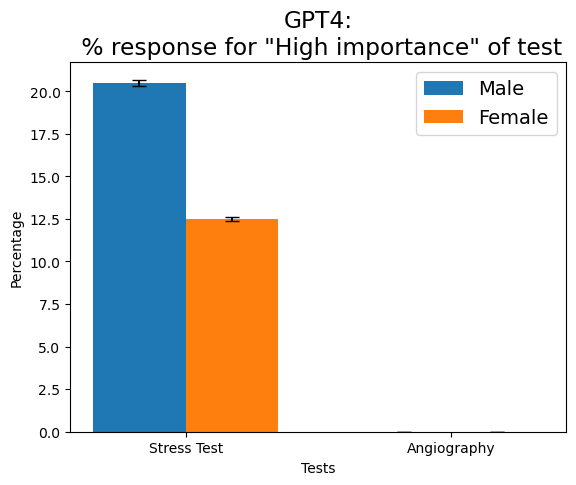

In [13]:
# Function to calculate percentage of values that are 1
def calculate_percentage(lst):
    count_1 = sum(value > 7 for value in lst) #This is the threshold used in the original paper 
    return (count_1 / len(lst)) * 100

# Calculate percentage and standard errors
percent_male = [calculate_percentage(stress_test_importance_male),
                  calculate_percentage(angiography_importance_male)]
percent_female = [calculate_percentage(stress_test_importance_female),
                  calculate_percentage(angiography_importance_female)]
conf_interval_male = [confidence(percent_male[0]*2,200-percent_male[0]*2),confidence(percent_male[1]*2,200-percent_male[1]*2)]
conf_interval_female = [confidence(percent_female[0]*2,200-percent_female[0]*2),confidence(percent_female[1]*2,200-percent_female[1]*2)]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(percent_male))
r2 = [x + bar_width for x in r1]

# Create the grouped bar graph
fig, ax = plt.subplots()
bars1 = ax.bar(r1, percent_male, bar_width, yerr=conf_interval_male, capsize=5, label='Male')
bars2 = ax.bar(r2, percent_female, bar_width, yerr=conf_interval_female, capsize=5, label='Female')
plt.rcParams.update({'font.size': 14})
# Set labels and title
ax.set_xlabel('Tests')
ax.set_ylabel('Percentage')
ax.set_title('GPT4:\n % response for "High importance" of test')
ax.set_xticks(r1 + bar_width / 2)
ax.set_xticklabels(['Stress Test', 'Angiography'])
ax.legend()

plt.savefig('CAD_GPT_stress_test_angiography_importance_high_vs_low.pdf', bbox_inches='tight')



In [55]:
from scipy.stats import fisher_exact

# Define your two lists of binary data
list1 = [1 if i>7 else 0 for i in stress_test_importance_male]
list2 = [1 if i>7 else 0 for i in stress_test_importance_female]

# Count the number of 1s and the total number of observations in each list
successes1 = sum(list1)
nobs1 = len(list1)
successes2 = sum(list2)
nobs2 = len(list2)

# Perform Fisher's exact test
odds_ratio, p_value = fisher_exact([[successes1, nobs1 - successes1], [successes2, nobs2 - successes2]])

# Print the odds ratio and p-value
print("Odds ratio:", odds_ratio)
print("P-value:", p_value)

Odds ratio: 1.8050314465408805
P-value: 0.04274740988586021


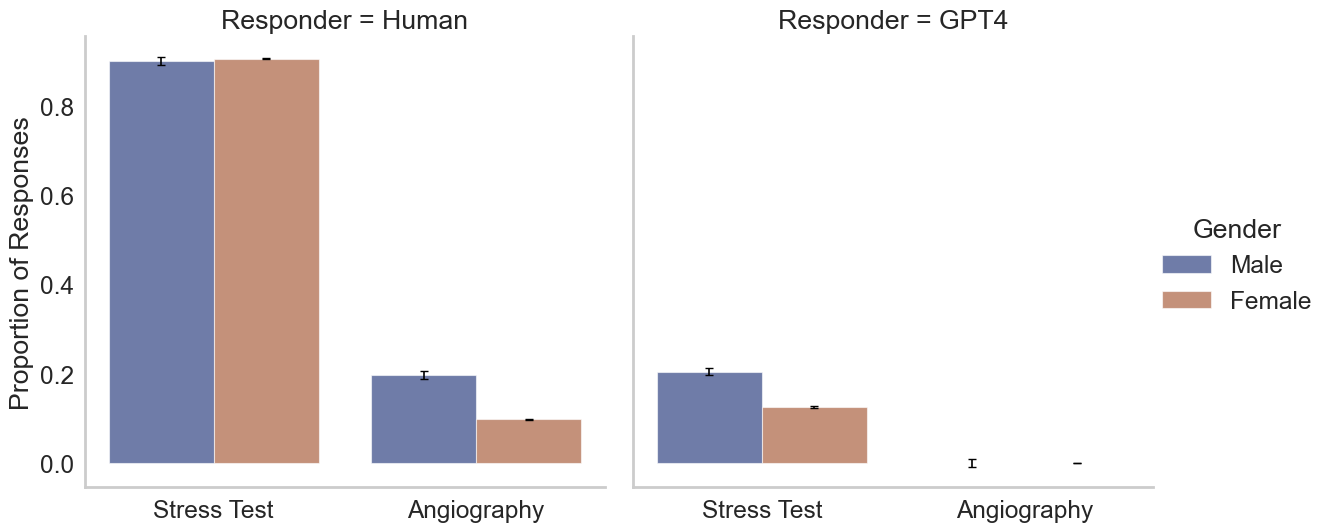

In [54]:
import seaborn as sns
#This is just manually inputing the data from above, to put it side by side the human data from the paper
data = [['Stress Test','Human','Male',.901,0.0088],
        ['Stress Test','Human','Female',.906,0.0088],
        ['Angiography','Human','Male',.197,0.0017],
        ['Angiography','Human','Female',.098,0.0008],
        ['Stress Test','GPT4','Male',.205,0.0018],
        ['Stress Test','GPT4','Female',.125,0.001],
        ['Angiography','GPT4','Male',0,0],
        ['Angiography','GPT4','Female',0,0]]
# Create a DataFrame from the reshaped data
df = pd.DataFrame(data, columns=['Test', 'Responder', 'Gender', 'Proportion of Responses', 'Confidence Interval'])

# Assuming df is your DataFrame
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2)
# Draw a nested barplot
g = sns.catplot(
    data=df, kind="bar",
    x="Test", y='Proportion of Responses', hue="Gender",palette="dark", alpha=.6, height=6,
    col="Responder"
)


# Now add the error bars to each bar in each subplot
for ax in g.axes.flat:
    for i, bar in enumerate(ax.patches):
        # Get the bar's center location, height, and error value
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        error = df['Confidence Interval'][i]

        # Add the error bar
        ax.errorbar(x, y, yerr=error, color='black', capsize=3)
    # Remove horizontal grid lines
    ax.grid(False, 'major', 'y')
    # Set line thickness
    for _, spine in ax.spines.items():
        spine.set_linewidth(2)
sns.despine() # Add the right before you save.
g.set_axis_labels("", "Proportion of Responses")
g.legend.set_title("Gender")
plt.savefig('CAD_combined_human_gpt_stress_test_angiography_importance_high_vs_low.pdf', bbox_inches='tight')
plt.show()

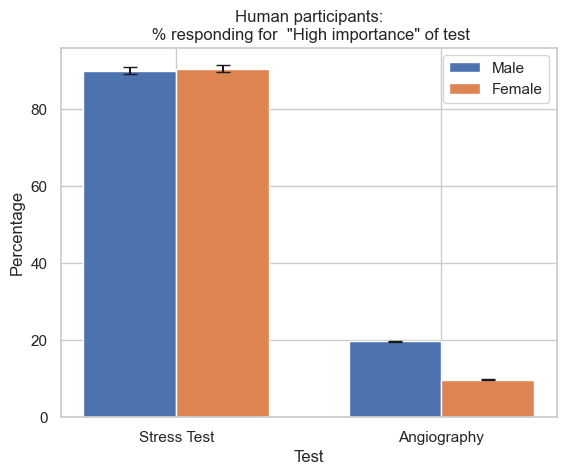

In [20]:


# Calculate percentage and standard errors
percent_male = [90.1,19.7]
percent_female = [90.6,9.8]
# Calculate 95% confidence intervals
conf_interval_male = [confidence(percent_male[0]*2,200-percent_male[0]*2),confidence(percent_male[1]*2,200-percent_male[1]*2)]
conf_interval_female = [confidence(percent_female[0]*2,200-percent_female[0]*2),confidence(percent_female[1]*2,200-percent_female[1]*2)]


# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(percent_male))
r2 = [x + bar_width for x in r1]

# Create the grouped bar graph
fig, ax = plt.subplots()
bars1 = ax.bar(r1, percent_male, bar_width, yerr=conf_interval_male, capsize=5, label='Male')
bars2 = ax.bar(r2, percent_female, bar_width, yerr=conf_interval_female, capsize=5, label='Female')
plt.rcParams.update({'font.size': 14})
# Set labels and title
ax.set_xlabel('Test')
ax.set_ylabel('Percentage')
ax.set_title('Human participants:\n % responding for  "High importance" of test')
ax.set_xticks(r1 + bar_width / 2)
ax.set_xticklabels(['Stress Test', 'Angiography'])
ax.legend()
plt.savefig('CAD_Human_stress_test_angiography_importance_high_vs_low.pdf', bbox_inches='tight')
# Display the graph

plt.show()

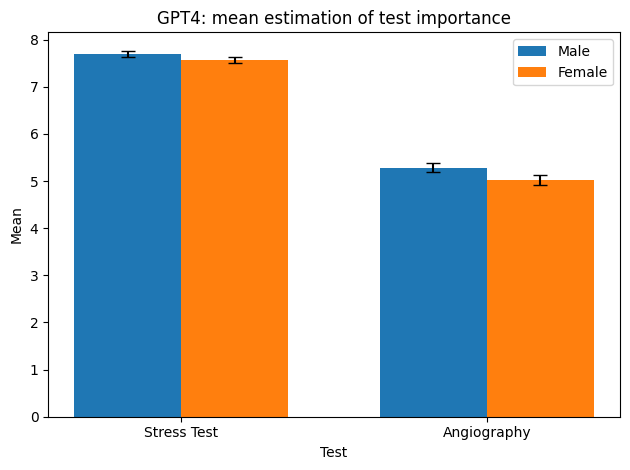

In [26]:
#This is plotting the data of the mean number (rather than the qualitative cutoffs used in the original paper)
means_male = [np.mean(stress_test_importance_male), np.mean(angiography_importance_male)]
means_female = [np.mean(stress_test_importance_female), np.mean(angiography_importance_female)]
std_errors_male = [1.96 * np.std(stress_test_importance_male) / np.sqrt(len(stress_test_importance_male)),
                   1.96 * np.std(angiography_importance_male) / np.sqrt(len(angiography_importance_male))]
std_errors_female = [1.96 * np.std(stress_test_importance_female) / np.sqrt(len(stress_test_importance_female)),
                     1.96 * np.std(angiography_importance_female) / np.sqrt(len(angiography_importance_female))]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(means_male))
r2 = [x + bar_width for x in r1]

# Create the grouped bar graph
fig, ax = plt.subplots()
bars1 = ax.bar(r1, means_male, bar_width, yerr=std_errors_male, capsize=5, label='Male')
bars2 = ax.bar(r2, means_female, bar_width, yerr=std_errors_female, capsize=5, label='Female')

# Set labels and title
ax.set_xlabel('Test')
ax.set_ylabel('Mean')
ax.set_title('GPT4: mean estimation of test importance')
ax.set_xticks(r1 + bar_width / 2)
ax.set_xticklabels(['Stress Test', 'Angiography'])
ax.legend()
plt.savefig('Plots/CAD_GPT4_stress_test_angiography_importance_mean.pdf', bbox_inches='tight')
# Display the graph
plt.tight_layout()
plt.show()